## A. Load Libraries:

In [1]:
import sys
sys.path.append('core')
from hydromet import*

---

## B. Run EventsTable Notebook:

### Specify:

In [2]:
## Excess rainfall parameters:
CN = 85                    # Curve number
volume = 2                   # NOAA Atlas 14 volume
region = 1                   # NOAA Atlas 14 region
durations = [6, 12, 24, 96]  # Calculate multiple durations 
#durations = [6]            # Calcuate a single duration


## Grouping parameters:
tempEpsilon_dic = {'6': 1, '12': 2, '24': 4, '96': 16} 
tempEpsilon2_dic = {'6': 0.5, '12': 1, '24': 2, '96': 8}
convEpsilon_dic = {'6': 100, '12': 100, '24': 100, '96': 100}
volEpsilon_dic = {'6': 67, '12': 67, '24': 67, '96': 67} 


### Filenames and paths:
AOI = 'DC'     # Area of interest
Model = 'P01'  # Model name
BCN = 'D01'    # Boundary condition name
precip_table = 'PrecipTable_{0}.xlsx'.format(AOI) 

root_dir = pl.Path(os.getcwd())
inputs_dir = root_dir/'Inputs'
outputs_dir = root_dir/'Outputs'
notebook_dir = root_dir/'Notebooks'
precip_table_dir = outputs_dir/precip_table
datarepository_dir = root_dir/'DataRepository'
bin_dir = root_dir/'bin'


## Options:
seed = np.random.randint(low=0, high=10000)
papermill = False 
display_plots = True
display_print = True
save_dss = True
remove_ind_dur = False #Remove individual duration files which are combined at the end of this notebook

### Run:

In [3]:
print("Randomly selected seed: {0}".format(seed))

if not os.path.exists(notebook_dir): os.mkdir(notebook_dir)
    
nb_executed = {}

for dur in durations:
    nb_executed[str(dur)] = str(notebook_dir/'EventsTable_{0}_Dur{1}_tempE{2}_{3}_convE{4}_volE{5}.ipynb'.format(AOI, dur,
                                                                                                                 tempEpsilon_dic[str(dur)], 
                                                                                                                 tempEpsilon2_dic[str(dur)], 
                                                                                                                 convEpsilon_dic[str(dur)], 
                                                                                                                 volEpsilon_dic[str(dur)]))
    print( nb_executed[str(dur)])
    nb_parameters = {'CN': CN,
                     'volume': volume,
                     'region': region,
                     'duration': dur,
                     'tempEpsilon': tempEpsilon_dic[str(dur)],
                     'tempEpsilon2': tempEpsilon2_dic[str(dur)],
                     'convEpsilon': convEpsilon_dic[str(dur)],
                     'volEpsilon': volEpsilon_dic[str(dur)],
                     'AOI': AOI,
                     'precip_table_dir': str(precip_table_dir),
                     'datarepository_dir': str(datarepository_dir),
                     'bin_dir': str(bin_dir),
                     'outputs_dir': str(outputs_dir),
                     'seed': seed,
                     'papermill': papermill,
                     'display_plots': display_plots,
                     'display_print': display_print,
                     'save_dss': save_dss}
    
    pm.execute_notebook('EventsTable.ipynb', nb_executed[str(dur)], parameters = nb_parameters);
    
    nb = nb_executed[str(dur)]
    ! jupyter nbconvert $nb --log-level ERROR

Randomly selected seed: 2149
C:\Users\sputnam\Documents\GitHub\pfra-hydromet\Notebooks\EventsTable_DC_Dur6_tempE1_0.5_convE100_volE67.ipynb


c:\users\sputnam\appdata\local\continuum\anaconda3\lib\site-packages\nbconvert\filters\datatypefilter.py:41: UserWarning: Your element with mimetype(s) dict_keys(['application/scrapbook.scrap.json+json']) is not able to be represented.
  mimetypes=output.keys())


C:\Users\sputnam\Documents\GitHub\pfra-hydromet\Notebooks\EventsTable_DC_Dur12_tempE2_1_convE100_volE67.ipynb


c:\users\sputnam\appdata\local\continuum\anaconda3\lib\site-packages\nbconvert\filters\datatypefilter.py:41: UserWarning: Your element with mimetype(s) dict_keys(['application/scrapbook.scrap.json+json']) is not able to be represented.
  mimetypes=output.keys())


C:\Users\sputnam\Documents\GitHub\pfra-hydromet\Notebooks\EventsTable_DC_Dur24_tempE4_2_convE100_volE67.ipynb


c:\users\sputnam\appdata\local\continuum\anaconda3\lib\site-packages\nbconvert\filters\datatypefilter.py:41: UserWarning: Your element with mimetype(s) dict_keys(['application/scrapbook.scrap.json+json']) is not able to be represented.
  mimetypes=output.keys())


C:\Users\sputnam\Documents\GitHub\pfra-hydromet\Notebooks\EventsTable_DC_Dur96_tempE16_8_convE100_volE67.ipynb


c:\users\sputnam\appdata\local\continuum\anaconda3\lib\site-packages\nbconvert\filters\datatypefilter.py:41: UserWarning: Your element with mimetype(s) dict_keys(['application/scrapbook.scrap.json+json']) is not able to be represented.
  mimetypes=output.keys())


### Display the results:

#### Open the executed notebook and extract the scraps:

In [4]:
final_reduction_dic = {}

for dur in durations:
    nb = sb.read_notebook(nb_executed[str(dur)])
    final_reduction_dic[str(dur)] = nb.scraps['final_reduction_lst'][1]

#### Final incremental excess rainfall results (combined events):

In [5]:
for dur in durations:
    print("Number of curves reduced by {0}% or {1} curves out of {2} remaining".format(np.round(final_reduction_dic[str(dur)][0], 2), final_reduction_dic[str(dur)][1], final_reduction_dic[str(dur)][2]))

Number of curves reduced by 92.95% or 362 curves out of 5132 remaining
Number of curves reduced by 92.54% or 383 curves out of 5137 remaining
Number of curves reduced by 92.09% or 407 curves out of 5147 remaining
Number of curves reduced by 88.97% or 568 curves out of 5150 remaining


### Combine the results for all durations and save:

#### Excess rainfall:

In [6]:
excess_dic = combine_results('Excess_Rainfall', outputs_dir, AOI, durations, tempEpsilon_dic, convEpsilon_dic, volEpsilon_dic, BCN, remove_ind_dur)

with open(outputs_dir/'{0}_{1}.json'.format(AOI, Model), 'w') as f:
    json.dump(excess_dic, f)

#### Event weights:

In [46]:
weights_dic = combine_results('Weights', outputs_dir, AOI, durations, tempEpsilon_dic, convEpsilon_dic, volEpsilon_dic, BCN, remove_ind_dur)

pd.DataFrame.from_dict(weights_dic).to_csv(outputs_dir/'Weights_{0}.csv'.format(AOI))

Total Weight: 0.5


#### Metadata:

In [16]:
metadata = combine_metadata(outputs_dir, AOI, durations, tempEpsilon_dic, convEpsilon_dic, volEpsilon_dic, BCN, remove_ind_dur)

with open(outputs_dir/'Metadata_{0}_{1}.json'.format(AOI, Model), 'w') as f:
    json.dump(metadata, f)       

### QC the combined results:

#### Plot the weight versus the total runoff for each group

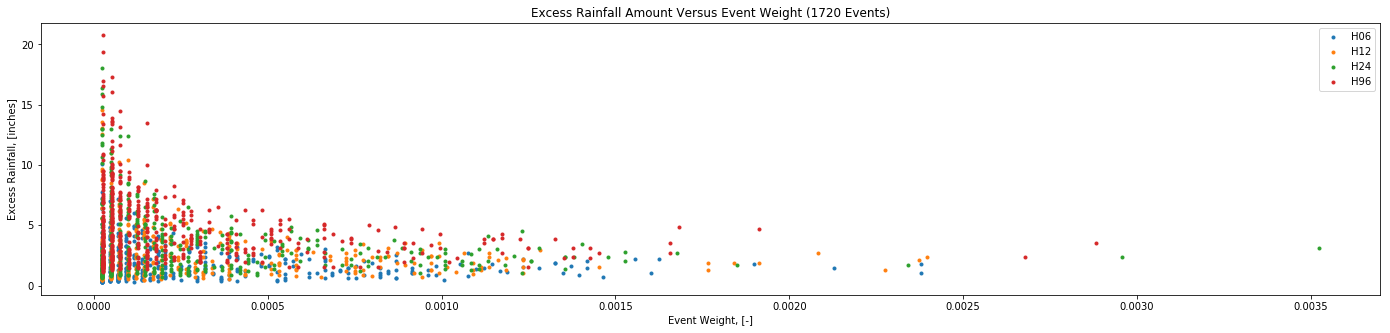

In [83]:
plot_amount_vs_weight(weights_dic, excess_dic, BCN)

---

## C. Run ReducedEvents Notebook:

### Specify:

### Run:

## End